In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.applications import resnet
import os
from PIL import Image

In [2]:
TRAINING_DIR = "./data/train"
MODEL_SAVE_FILE = "models/pepe-model.h5"
image_size = (224, 224)
batch_size = 32

In [4]:
def rewrite_gif_to_png(file_path):
    new_file_path = os.path.splitext(file_path)[0] + ".png"
        
    img = Image.open(file_path)
    img.save(new_file_path, optimize=True)
    img.close()

    os.remove(file_path)

In [5]:
for category in os.listdir(TRAINING_DIR):
    cat_path = os.path.join(TRAINING_DIR, category)
    
    for f in os.listdir(cat_path):
        if (f[-4:] != ".gif"):
            continue
    
        file_path = os.path.join(cat_path, f)
        rewrite_gif_to_png(file_path)

In [6]:
ds = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR, labels="inferred", image_size=image_size, batch_size=batch_size)

Found 6654 files belonging to 2 classes.


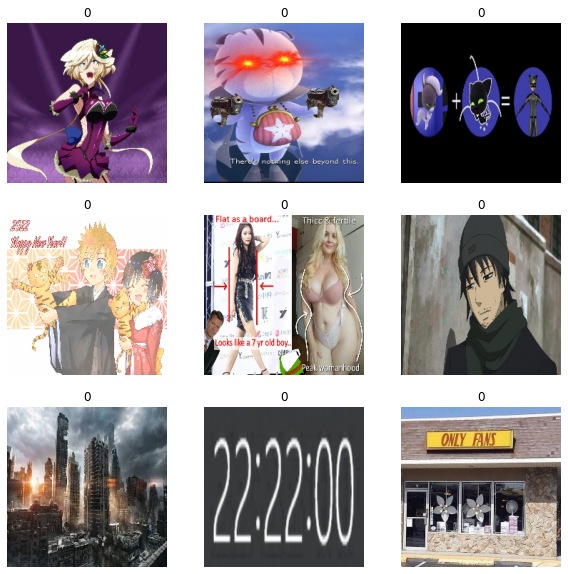

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [41]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [42]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = resnet.preprocess_input(x)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [10]:
if (os.path.isfile(MODEL_SAVE_FILE)):
    model.load_weights(MODEL_SAVE_FILE)

In [43]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("models/backup/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(ds, epochs=epochs, callbacks=callbacks)

model.save_weights(MODEL_SAVE_FILE)

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9934

C:\Users\Axel\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


208/208 [==============================] - 56s 252ms/step - loss: 0.0231 - accuracy: 0.9934
Epoch 2/5
208/208 [==============================] - 59s 276ms/step - loss: 0.0180 - accuracy: 0.9943
Epoch 3/5
208/208 [==============================] - 57s 266ms/step - loss: 0.0144 - accuracy: 0.9955
Epoch 4/5
208/208 [==============================] - 55s 254ms/step - loss: 0.0169 - accuracy: 0.9950
Epoch 5/5
208/208 [==============================] - 52s 242ms/step - loss: 0.0150 - accuracy: 0.9941


In [39]:
img = keras.preprocessing.image.load_img("./training/train/pepe/1640970327516.jpg", target_size=image_size)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
score

array([0.3120795], dtype=float32)